# Tarea 1 - Aprendizaje de Máquina
## Clasificación y Regresión en vinos
**Descripción:** En este trabajo realizaremos un modelo de aprendizaje automatizado, para predecir la puntuación de calidad de un vino dependiendo de sus cualidades tales como acidez y azúcares, entre otros datos.

## 1. Implementación de librerias
Importamos las librerias con las que vamos a trabajar en este notebook, entre las cuales podemos apreciar numpy para trata numérica, matplotlib para mostrar gráficas, pandas para trata de DataFrames, scikit-learn para los modelos de aprendizaje y ucimlrepo para importar el dataset de los vinos.

In [1]:
!pip install -q ucimlrepo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

## 2. Importación del dataset
Importamos el dataset de vinos con el que vamos a trabajar.

In [3]:
wine_quality = fetch_ucirepo(id=186)

Transformamos el dataset a un DataFrame de pandas para despues poderlo procesar con la libreria scikit-learn.

In [4]:
wines_colors = pd.DataFrame(data=wine_quality.data.original.color, columns=wine_quality.data.other_names)
wq_df = pd.DataFrame(data=wine_quality.data.features, columns=wine_quality.data.feature_names)
wq_df['quality'] = wine_quality.data.targets
wq_df = pd.concat([wq_df, wines_colors], axis=1)

## 3. Exploración de datos
### ¿Qué significa cada variable?
- **fixed_acidity (acidez fija):** Ácidos no volátiles que no se evaporan fácilmente, como el ácido tartárico y málico. Aportan al sabor y estabilidad del vino.
- **volatile_acidity (acidez volátil):** Se refiere principalmente al ácido acético (como el del vinagre). En pequeñas cantidades es normal, pero si es muy alta, indica deterioro del vino.
- **citric_acid	(ácido cítrico):** Presente naturalmente en algunas uvas. Añade frescura y sabor. También puede ayudar a prevenir la bacteriación.
- **residual_sugar (azúcar residual):** Es el azúcar que queda después de la fermentación. Los vinos secos tienen poca, los dulces tienen más. Influye en el sabor.
- **chlorides (cloruros):** Representan la cantidad de sal en el vino (generalmente cloruro de sodio). Exceso puede dar un sabor salado o amargo.
- **free_sulfur_dioxide (dióxido de azufre libre):** Parte del SO₂ que está disponible para proteger el vino contra bacterias y oxidación. Es el más "activo" en términos de protección.
- **total_sulfur_dioxide (dióxido de azufre total):** Incluye el SO₂ libre y el combinado. Un conservante común en vinos, pero en exceso puede dar aromas no deseados.
- **density (densidad):** Relación entre masa y volumen del vino. Puede indicar contenido de azúcar o alcohol. Un vino más dulce suele ser más denso.
- **pH:** Mide la acidez o alcalinidad. pH bajo = vino más ácido. No debe confundirse con la acidez total. Es importante para la estabilidad y sabor.
- **sulphates (sulfatos):** Añadidos a veces como conservantes. También pueden tener un rol en la estabilidad microbiológica del vino. En pequeñas cantidades no afectan el sabor.
- **quality (calidad):** calificación sensorial del vino dada por catadores expertos en una escala de 0 a 10.
- **color:** Indica si el vino es tinto (red) o blanco (white).

Vemos las primeras 10 filas para tener una primera información visual de cómo son los datos

In [5]:
wq_df.head(10)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,red
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,red
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,red
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,red
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,red


Vemos la estrucutra del dataframe, para identificar que tipo de datos lo componen y si existen valores nulos

In [6]:
wq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  color                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Como todos los datos son numéricos, podemos ver el resumen estadísitico de los datos. Acá podemos destacar que las siguientes columnas cuentan con outliers:
- **residual_sugar:** Tiene en 75% 8.1, pero su máximo es 65.8
- **chlorides:** Tiene en 75% 0.65, pero su máximo es 0.6
- **free_sulfur_dioxide:** Tiene en 75% 41, pero su máximo es 289
- **total_sulfur_dioxide:** Tiene en 75% 156, pero su máximo es 440
- **sulphates:** Tiene en 75% 0.6, pero su máximo es 2

In [7]:
wq_df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Visualizamos la distribución de la calidad

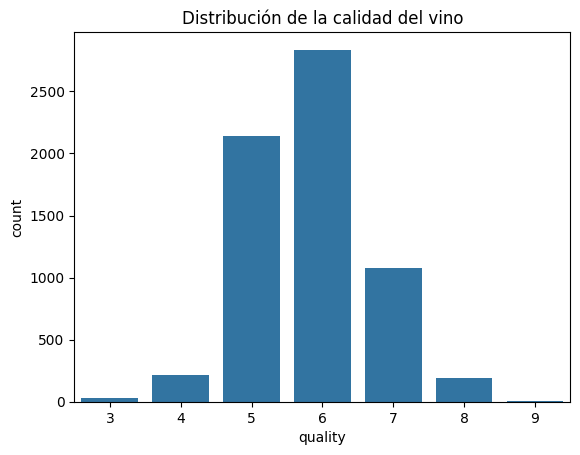

In [8]:
sns.countplot(x='quality', data=wq_df)
plt.title('Distribución de la calidad del vino')
plt.show()

In [9]:
wq_df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

Se puede observar como la mayoría de los vinos están clasificados con calidad 6 o 5, por lo que los datos están desbalanceados, siendo dificil para el modelo predecir para la calidad 3 o 9 Si bien existen outliers que se podrían eliminar, estos podrían afectar considerablemente a las clases minoritarias

Con la matriz de correlación podemos ver que el dióxido de azufre libre se encuentra dentro del dióxido de azufre total, generando una fuerte relación entre ambas variables, por lo que la eliminaremos mas adelante

Como los vinos tintos y blancos son inversamente proporcionales, eliminamos sus columnas luego de aplicar One-Hot Encoding y nos quedamos solo con la columna color cuyo nuevos valores son 1 para rojo (tinto) y 0 para blanco

In [10]:
#change wq_df color column to int64 0 if color is red 1 if color is white
print(wq_df['color'].unique())
wq_df['color'] = wq_df['color'].apply(lambda x: 1 if x == 'red' else 0)
wq_df['color_red'] = wq_df['color'].apply(lambda x: 1 if x == 1 else 0)
wq_df['color_white'] = wq_df['color'].apply(lambda x: 1 if x == 0 else 0)
print(wq_df)

['red' 'white']
      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_

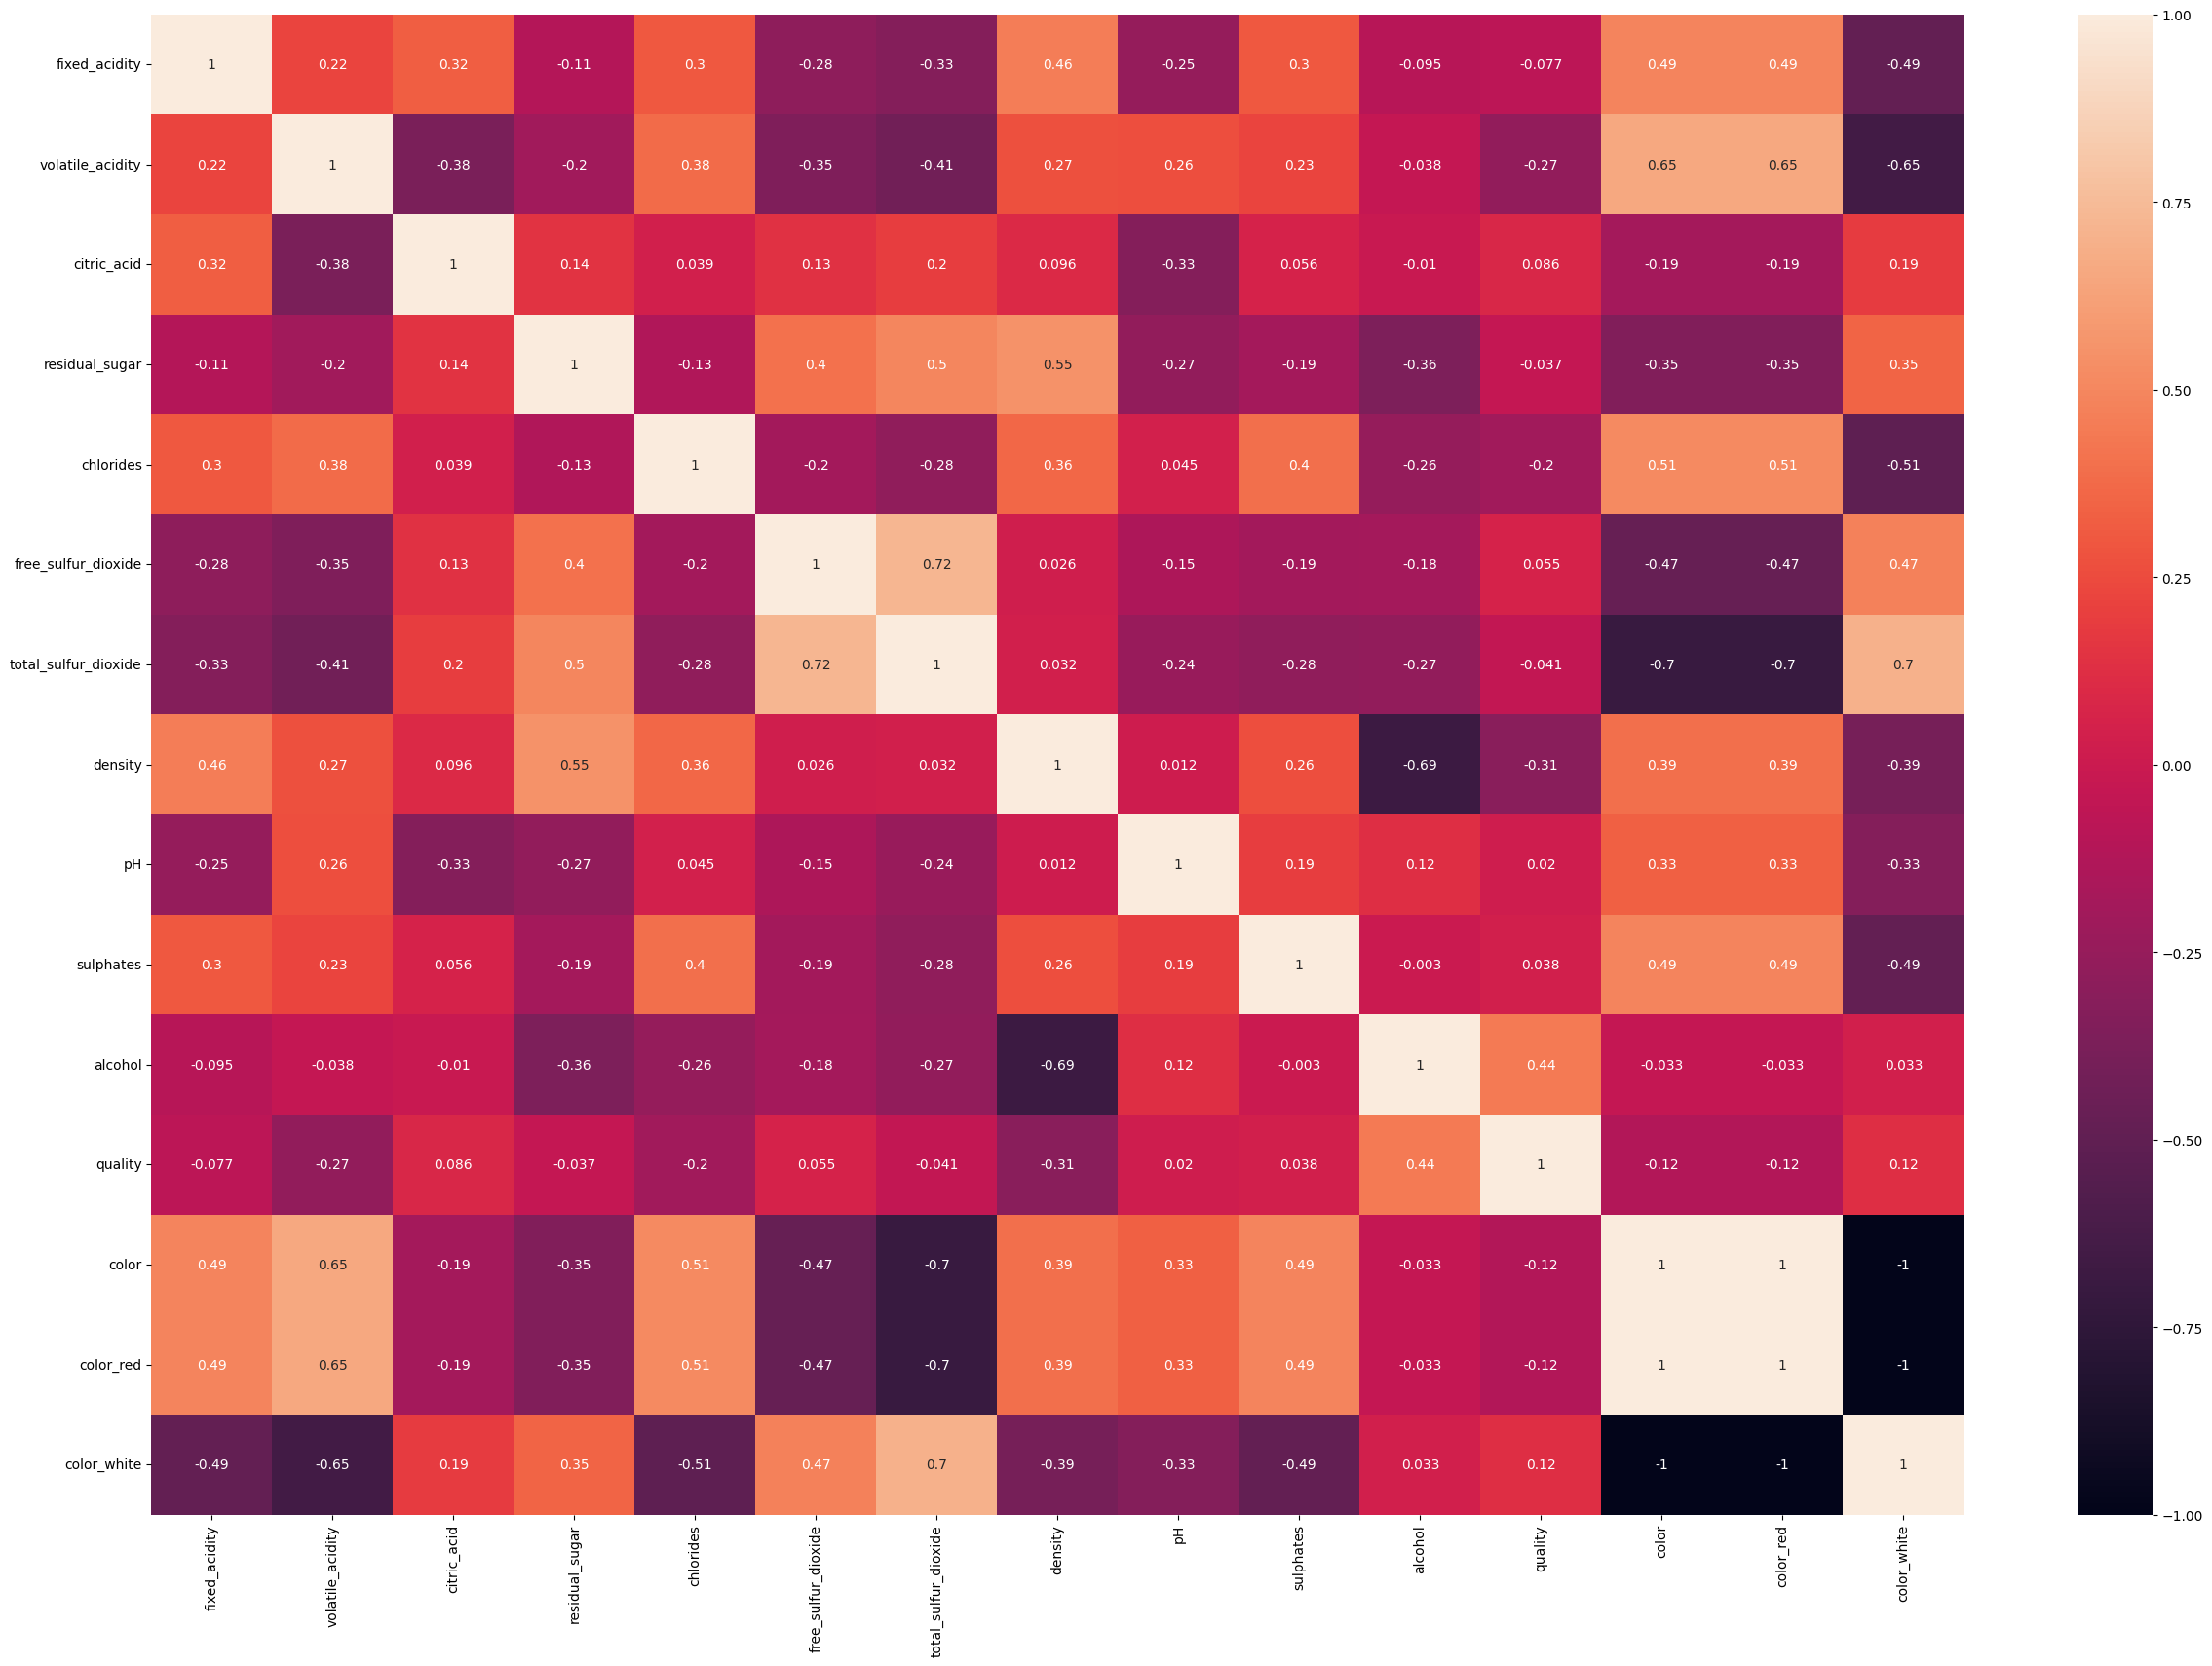

In [11]:
plt.figure(figsize=(30,20))
corr = wq_df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True)
plt.show()

In [12]:
#delete color_red and color_white columns
wq_df = wq_df.drop(['color_red', 'color_white', 'free_sulfur_dioxide'], axis=1)

In [13]:
wq_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,54.0,0.99700,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,60.0,0.99800,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,34.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,92.0,0.99114,3.27,0.50,11.2,6,0
6493,6.6,0.32,0.36,8.0,0.047,168.0,0.99490,3.15,0.46,9.6,5,0
6494,6.5,0.24,0.19,1.2,0.041,111.0,0.99254,2.99,0.46,9.4,6,0
6495,5.5,0.29,0.30,1.1,0.022,110.0,0.98869,3.34,0.38,12.8,7,0


## Escalado y Separación de datos de entrenamiento y validación

Generamos dos DataFrames nuevos, uno que contiene todos los datos a excepción de los resultados (la columna de 'calidad'), y otro que solamente contiene los resultados, con este par de DataFrames generamos cuatro DataFrames más:

1. **X_train:** datos para entrenar los modelos
2. **X_test:** datos con los que los modelos no trabajan, con la finalidad de usarlos en la fase de evaluación
3. **y_train:** datos de resultados con los cuales los modelos aprenden a predecir en base a la información entregada previamente
4. **y_test:** datos de resultados con los cuales los modelos no se entrenan, con la finalidad de evaluar los resultados en la fase de evaluación

In [14]:
X = wq_df.drop(columns = 'quality')
y = wq_df['quality']

In [15]:
# Aplicamos el escalado
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Dividir en conjunto de entrenamiento (80%) y prueba (20%), asegurando que todas las clases estén presentes en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=123, stratify=y)

## Desbalanceo
Hacemos sobremuestreo a las clases minoritarias con imbalanced-learn. Utilizamos SMOTE porque a diferencia del random no genera tanto sobreajuste y es menos costos computacionalmente en comparación con adasyn

In [16]:
smote = SMOTE(sampling_strategy='not majority', random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

C:\Users\ethan\anaconda3\envs\notebook\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ethan\anaconda3\envs\notebook\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ethan\anaconda3\envs\notebook\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ethan\anaconda3\envs\notebook\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ethan\anaconda3\envs\notebook\Lib\sub

In [17]:
print(f"Distribución original de clases: \n{y_train.value_counts()}")
print(f"Distribución después de ADASYN: \n{y_train_resampled.value_counts()}")

Distribución original de clases: 
quality
6    2269
5    1710
7     863
4     173
8     154
3      24
9       4
Name: count, dtype: int64
Distribución después de ADASYN: 
quality
5    2269
6    2269
7    2269
4    2269
8    2269
3    2269
9    2269
Name: count, dtype: int64


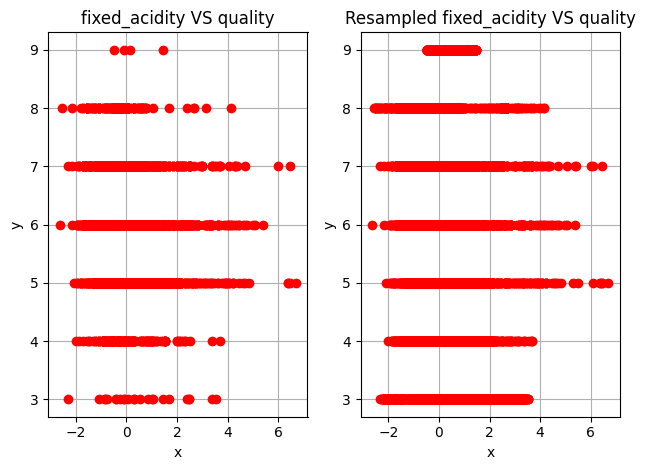

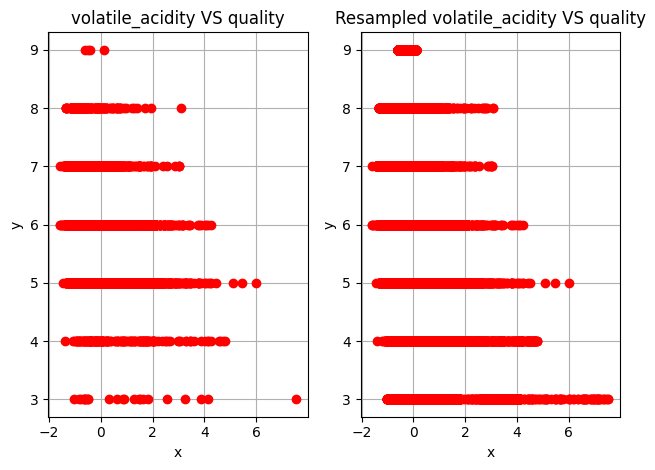

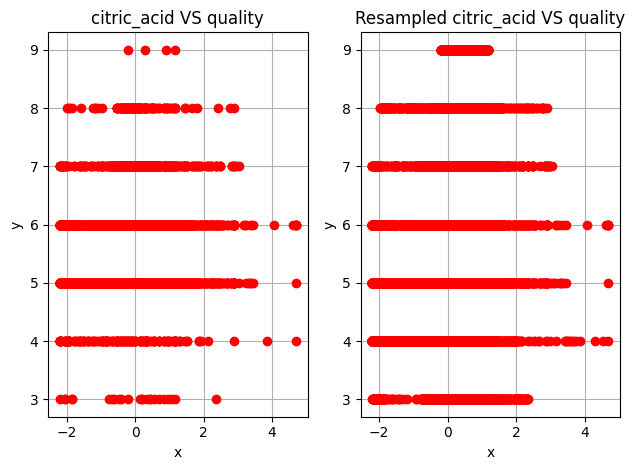

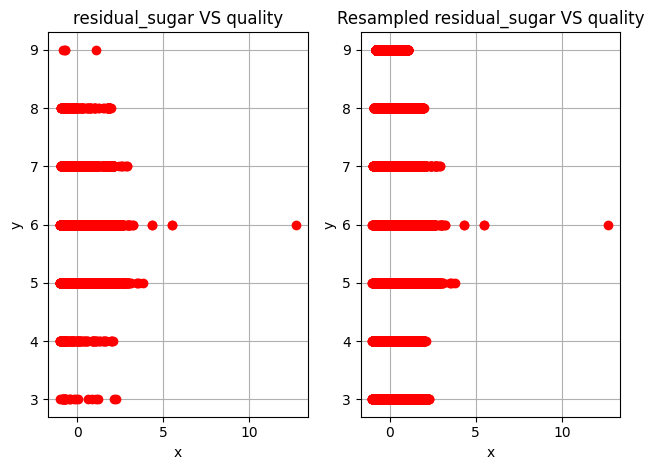

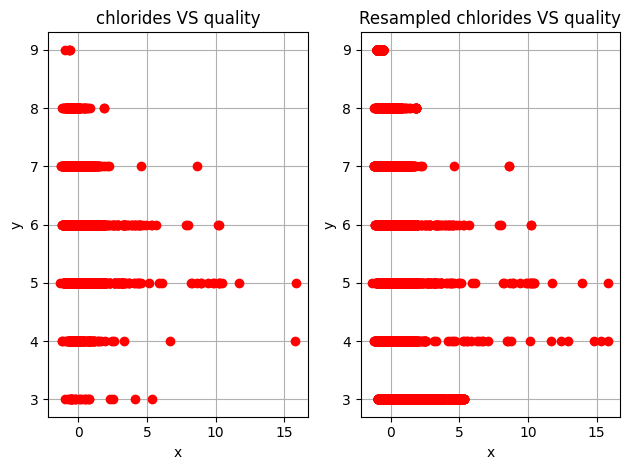

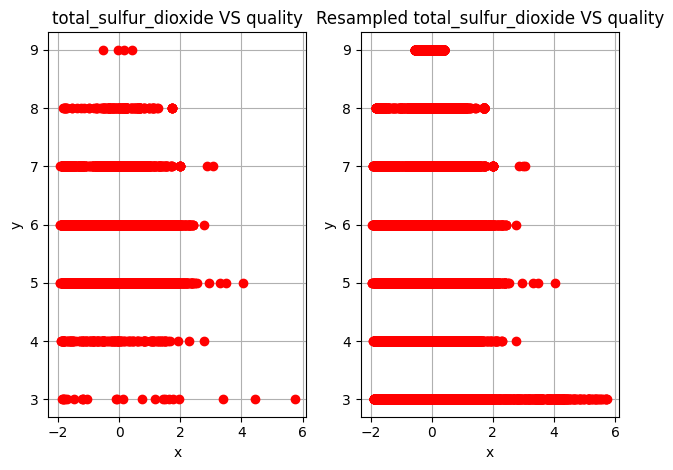

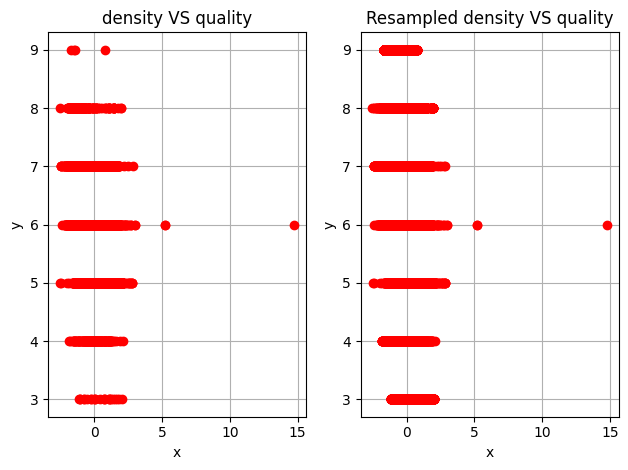

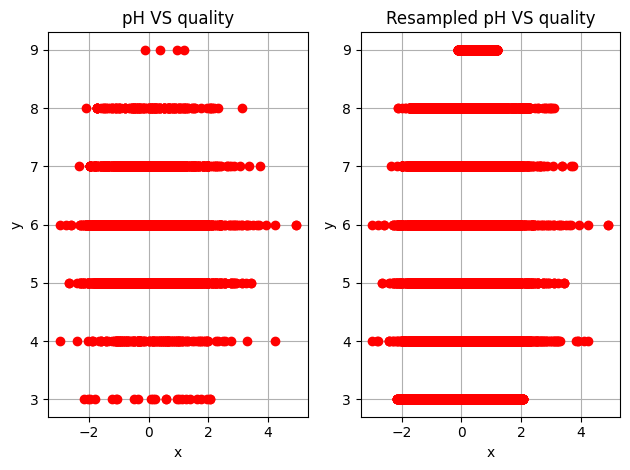

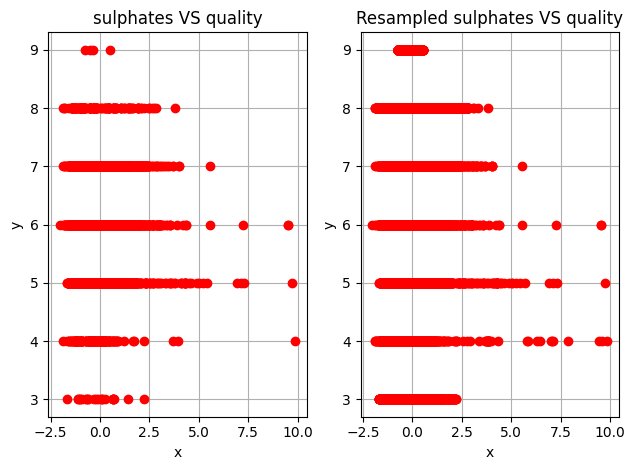

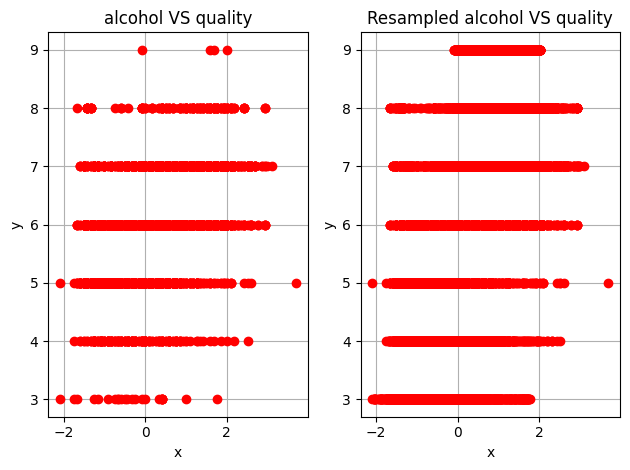

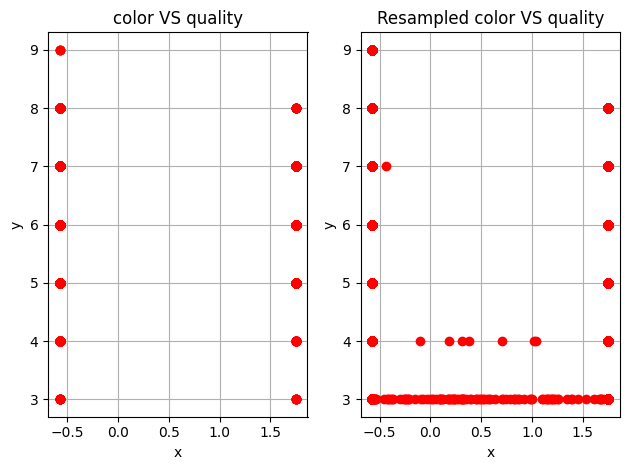

In [18]:
for attribute in X_train.columns:
  plt.subplot(1, 2, 1)
  plt.plot(X_train[attribute], y_train, 'ro')
  plt.grid(True)
  plt.title(f"{attribute} VS quality")
  plt.xlabel(r"x")
  plt.ylabel(r"y")

  plt.subplot(1, 2, 2)
  plt.plot(X_train_resampled[attribute], y_train_resampled, 'ro')
  plt.grid(True)
  plt.title(f"Resampled {attribute} VS quality")
  plt.xlabel(r"x")
  plt.ylabel(r"y")
  plt.tight_layout()
  plt.show()

# Clasificación
Los modelos de clasificación, como su nombre indica, clasifican los datos en clases, para este caso cada clase es la posible nota que reciba el vino, respecto a los resultados solo hay dos posibilidades, bien clasificado o mal clasificado. Procederemos a realizar el mismo procedimiento que realizamos para regresión, pero con el modelo que utilizaremos para clasificación. Debido a la similitud de los procesos solo se hablará de las diferencias.

## Modelo: RandomForestClassifier
Utilizamos Random Forest, ya que permite ajustar automáticamente la importancia de las clases mediante class_weight, ayudando a que el modelo no se sesgue hacia la clase mayoritaria, reduciendo el riesgo de sobreajuste y generalizando mejor en presencia de clases desbalanceadas.

In [19]:
# Definir los parámetros a ajustar para el Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'max_features': ['sqrt', 'log2', None],
}

# Crear el clasificador Random Forest
rf = RandomForestClassifier(random_state=42)

# Búsqueda aleatoria usando balanced_accuracy
random_search = RandomizedSearchCV(
    rf, param_grid, n_iter=20, cv=3, n_jobs=-1, verbose=2, scoring='balanced_accuracy', random_state=123
)
random_search.fit(X_train_resampled, y_train_resampled)

print(f"Mejores parámetros: {random_search.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'class_weight': None}


In [20]:
# Definir el modelo de Random Forest con los mejores hiperparámetros
model = RandomForestClassifier(
    n_estimators=random_search.best_params_['n_estimators'],
    criterion=random_search.best_params_['criterion'],
    max_depth=random_search.best_params_['max_depth'],
    min_samples_split=random_search.best_params_['min_samples_split'],
    min_samples_leaf=random_search.best_params_['min_samples_leaf'],
    class_weight=random_search.best_params_['class_weight'],
    max_features=random_search.best_params_['max_features'],
    random_state=42
)

# Entrenar el modelo
model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(criterion='entropy', min_samples_split=5,
                       n_estimators=200, random_state=42)

In [21]:
# Realizar predicciones
y_hat = model.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_hat, zero_division=0))


Reporte de clasificación:
              precision    recall  f1-score   support

           3       0.50      0.17      0.25         6
           4       0.26      0.26      0.26        43
           5       0.72      0.76      0.74       428
           6       0.69      0.67      0.68       567
           7       0.60      0.61      0.61       216
           8       0.34      0.33      0.34        39
           9       0.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.45      0.40      0.41      1300
weighted avg       0.66      0.66      0.66      1300



## Modelo: SVC
El modelo SVC no utiliza epsilon y se puede entregar el valor random_state, que permite definir una semilla para controlar la generación de valores pseudo aleatorios, si no definimos este valor, en cada iteración que se realice se cambiarán ciertos valores llevando a una inconsistencia en el trabajo.

In [22]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'random_state': [42],
    'max_iter': [50, 100, 500]
}

In [23]:
# Crear el modelo base
svc = SVC()

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_grid,
    n_iter=20,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)


In [24]:
# Entrenar Random Search
random_search.fit(X_train_resampled, y_train_resampled)

# Mejor modelo encontrado
best_svc = random_search.best_estimator_

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Mejor score en validación cruzada
print(f"Mejor accuracy en CV: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros encontrados:
{'random_state': 42, 'max_iter': 500, 'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
Mejor accuracy en CV: 0.6078


C:\Users\ethan\anaconda3\envs\notebook\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [25]:
# Realizar predicciones
y_hat = best_svc.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_hat, zero_division=0))


Reporte de clasificación:
              precision    recall  f1-score   support

           3       0.03      0.17      0.05         6
           4       0.16      0.35      0.22        43
           5       0.49      0.61      0.55       428
           6       0.44      0.12      0.19       567
           7       0.21      0.21      0.21       216
           8       0.10      0.67      0.17        39
           9       0.00      0.00      0.00         1

    accuracy                           0.32      1300
   macro avg       0.20      0.30      0.20      1300
weighted avg       0.39      0.32      0.31      1300



## Modelo: KNN

In [26]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_resampled, y_train_resampled)
y_pred = knn_classifier.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))


Reporte de clasificación:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.11      0.37      0.17        43
           5       0.60      0.60      0.60       428
           6       0.62      0.40      0.48       567
           7       0.47      0.56      0.51       216
           8       0.22      0.46      0.30        39
           9       0.00      0.00      0.00         1

    accuracy                           0.49      1300
   macro avg       0.29      0.34      0.30      1300
weighted avg       0.56      0.49      0.51      1300



In [27]:
# Definir los hiperparámetros a probar
param_dist = {
    'n_neighbors': range(1, 11),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1]
}

# Crear el modelo de Support Vector Machine
knn = KNeighborsClassifier()

# Búsqueda aleatoria
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=2,
    random_state=42
)

random_search.fit(X_train_resampled, y_train_resampled)

# Mejor modelo encontrado
best_knn = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\ethan\anaconda3\envs\notebook\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [28]:
# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Mejor score en validación cruzada
print(f"Mejor accuracy en CV: {random_search.best_score_:.4f}")

Mejores hiperparámetros encontrados:
{'weights': 'uniform', 'n_neighbors': 1, 'n_jobs': -1, 'metric': 'euclidean'}
Mejor accuracy en CV: -0.1125


In [29]:
# Realizar predicciones
y_hat = best_knn.predict(X_test)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_hat, zero_division=0))


Reporte de clasificación:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.19      0.37      0.25        43
           5       0.68      0.66      0.67       428
           6       0.68      0.63      0.65       567
           7       0.57      0.58      0.58       216
           8       0.31      0.38      0.34        39
           9       0.00      0.00      0.00         1

    accuracy                           0.61      1300
   macro avg       0.35      0.38      0.36      1300
weighted avg       0.63      0.61      0.62      1300



## Conclusión
De los tres modelos entrenados, Random Forest obtuvo el mejor resultado con un weighted average de precision, recall y f1-score aproximadamente del 0.66. Funcionando particularmente bien para las clases mayoritarias como la 5, 6 y 7. Sin embargo, falla en las clases minoritarias.

Cabe destactar que existen muy pocas observaciones para las clases 3 y 9, lo cual dificulta tanto el entrenamiento como el testeo, siendo casi imposible predecir la clase 9.

De eliminar los outliers podríamos mejorar los modelos, pero eso afectaría a las clases minoritarias.

